##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [4]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from functools import partial
from multiprocessing import Pool
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
importlib.reload(Dense)
importlib.reload(RSTF)

%matplotlib inline
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from ipywidgets import FloatProgress
from IPython.display import display
import os  

In [5]:
# def Curve(x,a,b,c,o):
#     return (a/(b+x)**c+o)

def Curve(x,a,b,c):
    return (a*x**2+b*x+c)

def Combos(Model,L,factor=None):
    Models=list()
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
    return(Models)

def TTV_Split(iteration,Memory,X,y,params,X_fill):
    params['seed'] = int(iteration%params['splits_per_mod']/params['splits_per_mod']*100)
    params['iteration'] = int(iteration/params['splits_per_mod'])
    X_train,X_test,y_train,y_test=train_test_split(X,y, test_size=0.1, random_state=params['seed'])
    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train, test_size=0.11, random_state=params['seed'])
    return(Dense.Train_Steps(params,X_train,X_test,X_val,y_train,y_test,
        y_val,X_fill = X_fill,Memory=Memory),
        y_val)

def RunReps(Model,params,pool = None,FullReturn=False):
    RST = RSTF.ReadStandardTimeFill(params['Dpath']+'ECData.csv')
    offset = 5/params['proc']
    Memory = (math.floor(100/params['proc'])- offset) * .01
    MSE = []
    RST.Scale(params['Y'],Model)
    if params['T'] >0:
        RST.TimeShape(params['T'])
    y = RST.y*1.0
    X = RST.X*1.0
    X_fill = RST.X_fill*1.0
    MSE = []
    R2 =[]
    Y_fill = []
    Yval = []
    y_val= []
    if __name__=='__main__'and params['proc'] != 1:
        for i,results in enumerate(pool.imap(partial(TTV_Split,Memory=Memory,X=X,y=y,params=params,X_fill=X_fill),range(params['K']))):
            Y_fill.append(results[0][0])
            Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
            y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
            MSE.append(metrics.mean_squared_error(Yval,y_val))
            R2.append(metrics.r2_score(Yval,y_val))
    else:
        for i in range(params['K']):
            results = TTV_Split(i,Memory,X,y,params,X_fill)
            Y_fill.append(results[0][0])
            Yval = RST.YScaled.inverse_transform(results[0][1].reshape(-1,1))
            y_val = RST.YScaled.inverse_transform(results[1].reshape(-1,1))
            MSE.append(metrics.mean_squared_error(y_val,Yval))
            R2.append(metrics.r2_score(y_val,Yval))
    Y_fill = np.asanyarray(Y_fill)
    Y_fill = Y_fill.mean(axis=0) 
    FillVarName = FillVar.replace('f','F')
    RST.Fill(Y_fill,FillVarName)
    return(MSE,R2,RST.Master['TempFill'])

def RunLoop(Runs,model):
    style = {'description_width': 'initial'}
    f = FloatProgress(min=0, max=Runs['N'].count(),description='Finding Best N:',style=style) # instantiate the bar
    display(f) # display the bar
    for N in Runs['N'].unique():
        params['T'] = 0
        params['N']=N
        Results = RunReps(model,params,pool)
        MSE = Results[0]
        R2 = Results[1]
        Runs.loc[Runs['N']==N,'MSE']=MSE
        Runs.loc[Runs['N']==N,'R2']=R2
        f.value+=params['K']
    return(Runs)

def N_Nodes(Runs,params,model,plot=False):
    Runs = RunLoop(Runs,model)
    Group = Runs.groupby('N').mean()
    Group['SD'] = Runs[['N','MSE']].groupby('N').std()
    Group['SE'] = Runs[['N','MSE']].groupby('N').sem()
    Group = Group.reset_index()
    Min = Group.loc[Group['MSE']==Group['MSE'].min()]
    popt, pcov = curve_fit(Curve, Runs['N'].values, Runs['MSE'].values)
    N = np.arange(Runs['N'].min(),Runs['N'].max())
    Fit = Curve(N,*popt)
    Max = (Min['MSE']+Min['SE']).values[0]
    try:
        params['N']=N[Fit<Max].min()
    except:
#         params['N']=N[-1]
        print('Fitting failed to produce meaningful results')
        params['N'] = Group.loc[Group['MSE']<+Min['MSE'].values[0]+Min['SE'].values[0],'N'].values[0]
        pass
    
    if plot == True:
        fig,ax = plt.subplots(figsize=(8,8))
        ax.scatter(Runs['N'],Runs['MSE'])
        ax.plot(N,Fit,color='r')
        ax.plot(N,N*0+Max,color = 'black')
        plt.grid()
        plt.show()
        print(params['N'])
    return(params)

def FactorTest(params,FullModel,Runs):
    prog1 = FloatProgress(min=0, max=len(FullModel)-1,description='FactorTesting:') # instantiate the bar
    display(prog1) # display the bar
    Scores = Runs[['MSE','R2']].reset_index(drop=True)
    Scores = (Scores.iloc[0:params['K']])*0
    Scores['Level'] = len(FullModel)
    Scores['Key'] = str(Scores['Level'][0])+'_0'
    Scores['Model'] = '+'.join(FullModel)
    Results = RunReps(FullModel,params,pool)
    MSE = Results[0]
    R2 = Results[1]
    Scores['MSE']=Results[0]
    Scores['R2']=Results[1]
    ModelRuns = Results[2]
    ModelRuns = ModelRuns.to_frame()
    ModelRuns['Model: '+'+'.join(FullModel)]=ModelRuns['TempFill']
    ModelRuns=ModelRuns.drop('TempFill',axis=1)
    for i in range(1,len(FullModel)):
        if i == 1:
            Models = Combos(FullModel,i)
        else:
            Models = Combos(FullModel,i,factor = Best)
        print('Number of Models: ',len(Models))
        prog2 = FloatProgress(min=0, max=len(Models),description='Level: '+str(i)) # instantiate the bar
        display(prog2) # display the bar
        Values = []
        Names = []
        for i,model in enumerate(Models):
            level = len(model)
            key = str(level)+'_'+str(i)
            Name = '+'.join(model)
            NewRow = Scores.iloc[-1].copy()
            NewRow['Model'] = 'Model: '+Name
            Results = RunReps(model,params,pool)
            MSE = Results[0]
            R2 = Results[1]
            d = {'Model':'+'.join(model),'MSE':MSE,'Key':key,'R2':R2,'Level':level}#,'Best':'N'
            score = pd.DataFrame(index=[x for x in range(params['K'])],data=d)
            Scores = Scores.append(score,ignore_index=True)#,sort=False)
            ModelRuns['Model: '+'+'.join(model)] = Results[2]    
            prog2.value+=1
        Group = Scores.groupby('Key').agg({'Model': 'first', 
            'Level': 'first','MSE': 'mean','R2': 'mean'})#.reset_index()#mean()  
        Group['SD'] = Scores[['Key','MSE']].groupby('Key').std()
        Group['SE'] = Scores[['Key','MSE']].groupby('Key').sem()
        Min = Group.loc[Group['Level']==level]
        Best = Min.loc[Min['MSE'] == Min['MSE'].min(),'Model'].values
        print(Best)  
        prog1.value+=1
    Group = Scores.groupby('Key').agg({'Model': 'first', 
        'Level': 'first','MSE': 'mean','R2': 'mean'})#.reset_index()#mean()  
    Group['SD'] = Scores[['Key','MSE']].groupby('Key').std()
    Group['SE'] = Scores[['Key','MSE']].groupby('Key').sem()
    Min = Group.loc[Group['Level']==level]

    Levels = Group.groupby('Level').min()
    Sub=Group[Group['MSE'].isin(Levels['MSE'].values)]
    print(Sub)
    Sub.sort_values('Level',inplace=True)
    Sub = Sub.loc[Sub['Level']>=1]
    Sub.reset_index(inplace=True,drop=True)
    Min = Sub.loc[Sub['MSE']==Sub['MSE'].min()]
    Parsimony = (Sub.loc[Sub['MSE']<(Min['MSE'].values+Min['SE'].values)[0]])
    Parsimony = Parsimony.loc[Parsimony['Level']==Parsimony['Level'].min()]
    print(Parsimony)
    Best = Parsimony['Model'].values
    return(Best,Scores,ModelRuns)
def Best_Fill(Best,Runs,Scores,params):
    N = Runs['N']
    NRuns = Runs*0
    NRuns['N']=N
    model = Best[0].split('+')

    params = N_Nodes(NRuns,params,model,plot=True)
    level = 0#len(Best)
    print(Best)
    key = '0_'+str(params['N'])
    Name = '+'.join(Best)
    NewRow = Scores.iloc[-1].copy()
    NewRow['Model'] = 'BestModel: '+Name
    Results = RunReps(model,params,pool)
    MSE = Results[0]
    R2 = Results[1]
    d = {'Model':'+'.join(model),'MSE':MSE,'Key':key,'R2':R2,'Level':level}#,'Best':'N'
    score = pd.DataFrame(index=[x for x in range(params['K'])],data=d)
    Scores = Scores.append(score,ignore_index=True)
    Scores = Scores.append(score,ignore_index=True)
    ModelRuns['BestModel: '+'+'.join(model)] = Results[2] 
    print(params['N'])
    return(Scores,ModelRuns)
#     print(Scores)
# pool.close()

# The "Optimum" Sized Model

{'Save': {'Weights': False, 'Model': False}, 'K': 20, 'Dpath': '/home/ubuntu/NetworkAnalysis/FishIsland/', 'splits_per_mod': 4, 'epochs': 200, 'proc': 3, 'Y': 'fco2'}


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


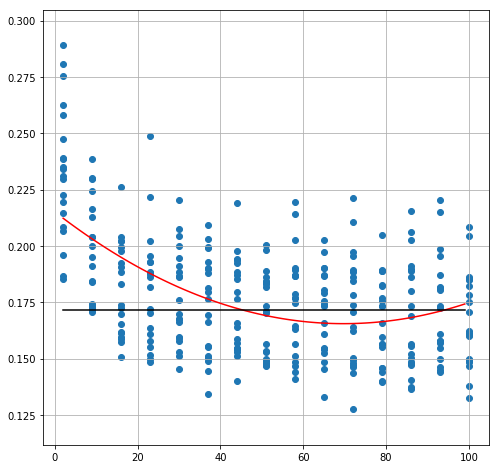

46


A Jupyter Widget

Number of Models:  14


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


['PPFD']
Number of Models:  13


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


['Ta+PPFD']
Number of Models:  12


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


['Ta+PPFD+Active Layer']
Number of Models:  11


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


['H+Ta+PPFD+Active Layer']
Number of Models:  10


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


['H+Wind Spd+Ta+PPFD+Active Layer']
Number of Models:  9


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


['H+Wind Spd+Ta+PPFD+VWC+Active Layer']
Number of Models:  8


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


['H+Wind Spd+Ta+PPFD+Water Table+VWC+Active Layer']
Number of Models:  7


A Jupyter Widget

['H+Wind Spd+Ta+Rn+PPFD+Water Table+VWC+Active Layer']
Number of Models:  6


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


['H+Wind Spd+Ta+Rn+PPFD+Water Table+VWC+Active Layer+Wtr Tbl Trnd']
Number of Models:  5


A Jupyter Widget

[ 'H+Wind Spd+air pressure+Ta+Rn+PPFD+Water Table+VWC+Active Layer+Wtr Tbl Trnd']
Number of Models:  4


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


[ 'H+Wind Spd+air pressure+Ta+Rn+PPFD+Water Table+VWC+Active Layer+24H Rain+Wtr Tbl Trnd']
Number of Models:  3


A Jupyter Widget

[ 'H+Wind Spd+air pressure+Ta+Rn+PPFD+Water Table+Ts 15 cm+VWC+Active Layer+24H Rain+Wtr Tbl Trnd']
Number of Models:  2


A Jupyter Widget

[ 'H+Wind Spd+air pressure+Ta+Rn+PPFD+Rain+Water Table+Ts 15 cm+VWC+Active Layer+24H Rain+Wtr Tbl Trnd']
            R2  Level       MSE  \
Key                               
10_0  0.780958     10  0.158986   
11_3  0.776256     11  0.162937   
12_2  0.768138     12  0.166230   
13_0  0.764558     13  0.167741   
14_0  0.758224     14  0.172694   
1_5   0.576629      1  0.265651   
2_3   0.620405      2  0.244089   
3_9   0.675468      3  0.217353   
4_0   0.707503      4  0.197097   
5_0   0.755179      5  0.172041   
6_6   0.770835      6  0.161383   
7_3   0.782824      7  0.155700   
8_1   0.785045      8  0.156612   
9_5   0.780358      9  0.157154   

                                                  Model        SD        SE  
Key                                                                          
10_0  H+Wind Spd+air pressure+Ta+Rn+PPFD+Water Table...  0.017160  0.003837  
11_3  H+Wind Spd+air pressure+Ta+Rn+PPFD+Water Table...  0.017884  0.003999  
12_2  H+Wind Spd+air p

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


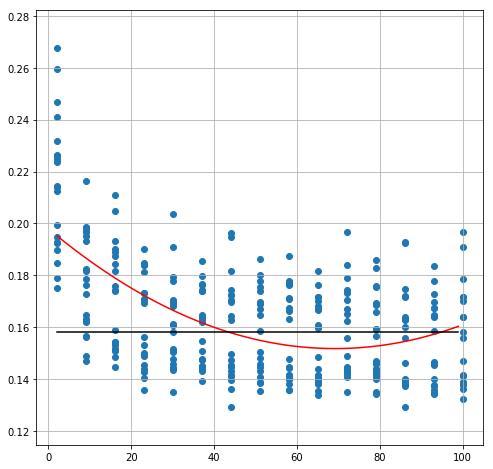

44
['H+Wind Spd+Ta+PPFD+Water Table+VWC+Active Layer']


Using TensorFlow backend.


44
44
8994.961411237717
{'Save': {'Weights': False, 'Model': False}, 'K': 20, 'Dpath': '/home/ubuntu/NetworkAnalysis/FishIsland/', 'splits_per_mod': 4, 'epochs': 200, 'proc': 3, 'Y': 'fch4'}


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


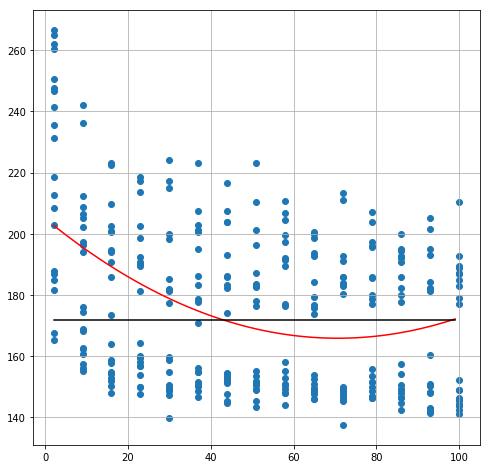

43


A Jupyter Widget

Number of Models:  14


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


['H']
Number of Models:  13


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


['H+VWC']
Number of Models:  12


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


['H+VWC+Active Layer']
Number of Models:  11


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


['H+Water Table+VWC+Active Layer']
Number of Models:  10


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.


['H+Ta+Water Table+VWC+Active Layer']
Number of Models:  9


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


['H+air pressure+Ta+Water Table+VWC+Active Layer']
Number of Models:  8


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


['H+air pressure+Ta+Water Table+VWC+Active Layer+24H Rain']
Number of Models:  7


A Jupyter Widget

Using TensorFlow backend.


['H+air pressure+Ta+Water Table+Ts 15 cm+VWC+Active Layer+24H Rain']
Number of Models:  6


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.


['H+air pressure+Ta+Rain+Water Table+Ts 15 cm+VWC+Active Layer+24H Rain']
Number of Models:  5


A Jupyter Widget

Using TensorFlow backend.


[ 'H+air pressure+Ta+PPFD+Rain+Water Table+Ts 15 cm+VWC+Active Layer+24H Rain']
Number of Models:  4


A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.


[ 'H+air pressure+Ta+PPFD+Rain+Water Table+Ts 2.5 cm+Ts 15 cm+VWC+Active Layer+24H Rain']
Number of Models:  3


A Jupyter Widget

[ 'H+Wind Spd+air pressure+Ta+PPFD+Rain+Water Table+Ts 2.5 cm+Ts 15 cm+VWC+Active Layer+24H Rain']
Number of Models:  2


A Jupyter Widget

[ 'H+Wind Spd+air pressure+Ta+Rn+PPFD+Rain+Water Table+Ts 2.5 cm+Ts 15 cm+VWC+Active Layer+24H Rain']
            R2  Level         MSE  \
Key                                 
10_2 -0.189717     10  163.513161   
11_2 -0.214794     11  165.483760   
12_0 -0.190458     12  167.866149   
13_0 -0.198945     13  168.218165   
14_0 -0.251232     14  172.732061   
1_0  -1.697951      1  230.318533   
2_9  -1.115053      2  208.147413   
3_9  -0.841125      3  199.439941   
4_6  -0.543301      4  184.269748   
5_2  -0.400816      5  176.837305   
6_1  -0.414616      6  172.491639   
7_6  -0.215934      7  165.482308   
8_5  -0.162122      8  161.724734   
9_3  -0.186418      9  163.738694   

                                                  Model         SD        SE  
Key                                                                           
10_2  H+air pressure+Ta+PPFD+Rain+Water Table+Ts 15 ...  14.647131  3.275198  
11_2  H+air pressure+Ta+PPFD+Rain+Water Table+Ts 2.5...  14.617427  

A Jupyter Widget

Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.
Using TensorFlow backend.


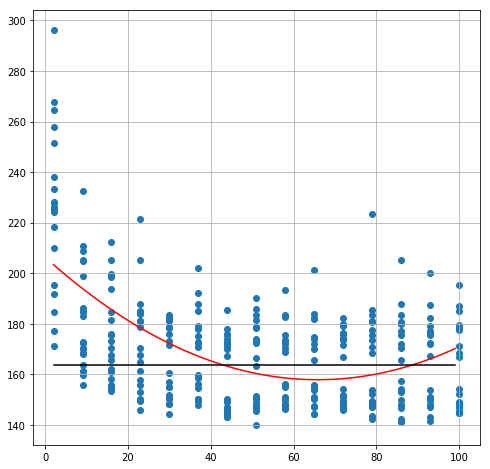

44
['H+air pressure+Ta+Water Table+Ts 15 cm+VWC+Active Layer+24H Rain']
44
44
6027.069519042969


In [6]:
# pool.close()
Site = 'FishIsland'#'Illisarvik'#
cwd = os.getcwd()
# FullModel = ['H','wind_speed','air_pressure','PPFD_Avg','AirTC_Avg',
#              'VPD','Temp','VWC','Sedge','Shrub','Grass','Sparse','Out_of_Basin']
# FullModel = ['PPFD_Avg','AirTC_Avg','Sedge']

FullModel = ['H','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table',
        'Ts 2.5 cm','Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd']

# FullModel = ['H','Water Table','Wind Spd','Active Layer']
MP=True
if __name__=='__main__'and MP==True:
    pool = Pool(processes=3,maxtasksperchild=75)
else:pool=None


for FillVar in ['fco2','fch4']:
# FillVar = 'fch4'https://ec2-52-33-244-45.us-west-2.compute.amazonaws.com:8888/kernelspecs/python3/logo-64x64.png
    Time = time.time()
    #     Path = 'Data_Footprints_2018-06-12.csv'
    Runs,params = Dense.Params('Full',FillVar,MP)
    params['Dpath'] = cwd+'/'+Site+'/'
    print(params)
    params = N_Nodes(Runs,params,FullModel,plot=True)
    Best,Scores,ModelRuns = FactorTest(params,FullModel,Runs)
    Best_Fill(Best,Runs,Scores,params)

    Scores.to_csv(params['Dpath']+FillVar+'/GapFillingSummary.csv')
    ModelRuns.to_csv(params['Dpath']+FillVar+'/GapFilled.csv')
    print(params['N'])
    print(time.time()-Time)

In [7]:
# 46